<a href="https://colab.research.google.com/github/josecn88/neuralNetwork/blob/main/redeNeural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projeto de uma Rede Neural, baseado no tutorial de  [pedroblossbraga]**(https://github.com/pedroblossbraga/Deep-Learning-Regression/blob/master/TF_Regress%C3%A3o_Previs%C3%A3o_do_Consumo_de_Combust%C3%ADvel.ipynb) sobre TensorFlow e Regressão.

Neste caso optou-se pelo dataset da simulação da trajetória do robô Pioneer 3AT utilizando um controlador H infinito. A intenção da Rede Neural aqui codificada, é prever as saídas do controle F0 e Fxe com base no vetor de erros xe.


**Instalação e importação das biliotecas aqui utilizadas**

In [66]:
!pip install -q seaborn
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


**Base de Dados:**

A base da dados foi extraída da simulação em Matlab, contendo as 4 dimenções da matrix de erros xe {Omega_L ,Omega_R, Posição e Orientação}, além das saídas do controlador F0 {Controle H infinito} e Fxe {Termo Adaptado}.





In [3]:
column_names = ['xe1','xe2','xe3','xe4','f01','f02','fxe1','fxe2']
dataset_puro = pd.read_excel('dataset.xlsx', names = column_names)

**Criação de uma cópia para processamento e aplicação do modelo**

In [4]:
dataset = dataset_puro.copy()
dataset.head()

,xe1,xe2,xe3,xe4,f01,f02,fxe1,fxe2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.000055,-0.000055,-0.000002,-0.000002,0.000000,0.000000,0.000000,0.000000
2,-0.000168,-0.000168,-0.000009,-0.000009,0.000128,0.000128,0.000007,0.000007
3,-0.000271,-0.000271,-0.000020,-0.000020,7.878922,-6.064276,0.000032,0.000032
4,-0.000349,-0.000349,-0.000034,-0.000034,7.879161,-6.064036,0.000077,0.000077


In [5]:
dataset.describe()

,xe1,xe2,xe3,xe4,f01,f02,fxe1,fxe2
count,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000
mean,0.016600,0.016617,-0.000640,-0.002885,0.014382,1.092562,-0.365171,0.472927
std,0.116560,0.127325,0.023136,0.034101,7.280348,7.243692,0.858191,0.943051
min,-4.476779,-2.933595,-0.077627,-0.191664,-13.404931,-11.703886,-4.472717,-4.548078
25%,-0.009383,-0.005682,-0.012732,-0.003739,-6.251751,-6.100721,-0.564963,-0.000139
50%,-0.000019,0.000026,-0.000386,0.000061,-5.973896,6.894619,-0.019893,0.078796
75%,0.006386,0.007699,0.002966,0.015131,7.844266,7.845821,0.078260,0.732114
max,2.167643,4.778686,0.265535,0.126046,11.743496,11.626806,3.268061,4.829295


**Limpeza e tratamento dos dados**

É possivel verificar que não existes NaN e há poucos valores duplicados.

In [6]:
dataset.isna().sum()

xe1     0
xe2     0
xe3     0
xe4     0
f01     0
f02     0
fxe1    0
fxe2    0
dtype: int64

In [7]:
for col in dataset.columns:
  print(f" col {col} , Qtd de valores únicos: {len(dataset[col].unique())} , {list(dataset[col].unique())} \n ")

 col xe1 , Qtd de valores únicos: 3999 , [0.0, -5.539364960158682e-05, -0.00016794591768764375, -0.00027099923918433213, -0.00034895624436888806, -0.0004014492597730968, -0.00043209690559627405, -0.0004450764382497368, -0.0004441621451869832, -0.0004325267484181143, -0.0004127664299457068, -0.0003869809099087858, -0.00035685775774738776, -0.00032374716935764, -0.00028872482106887323, -0.00025264367716495637, -0.00021617636625673002, -0.000179849734221511, -0.00014407297516205904, -0.0001091605142735548, -7.535060871086824e-05, -4.282045702999268e-05, -1.1698462620026578e-05, 1.7925822718992124e-05, 4.599364556266347e-05, 7.247053665921169e-05, 9.734104838391572e-05, 0.00012060450904024383, 0.00014227160326175242, 0.00016236162348872915, 0.0001809002670329074, 0.00019791787626104868, 0.00021344803886024638, 0.00022752647995440134, 0.00024019019076468306, 0.0002514767484139216, 0.00026142379012907696, 0.00027006861154839357, 0.00027744786506379154, 0.00028359733797529707, 0.0002885517945

**Separação em Dados de Treinamento e Teste**

Definiu-se a porcentagem de divisão em 80%

In [9]:
pct_split = 0.8

train_dataset = dataset.sample(frac=pct_split, random_state=0)


Foi realizada a retirada dos dados de teste do conjunto de treinamento.

In [10]:
test_dataset = dataset.drop(train_dataset.index)

**Pair-plots dos dados**

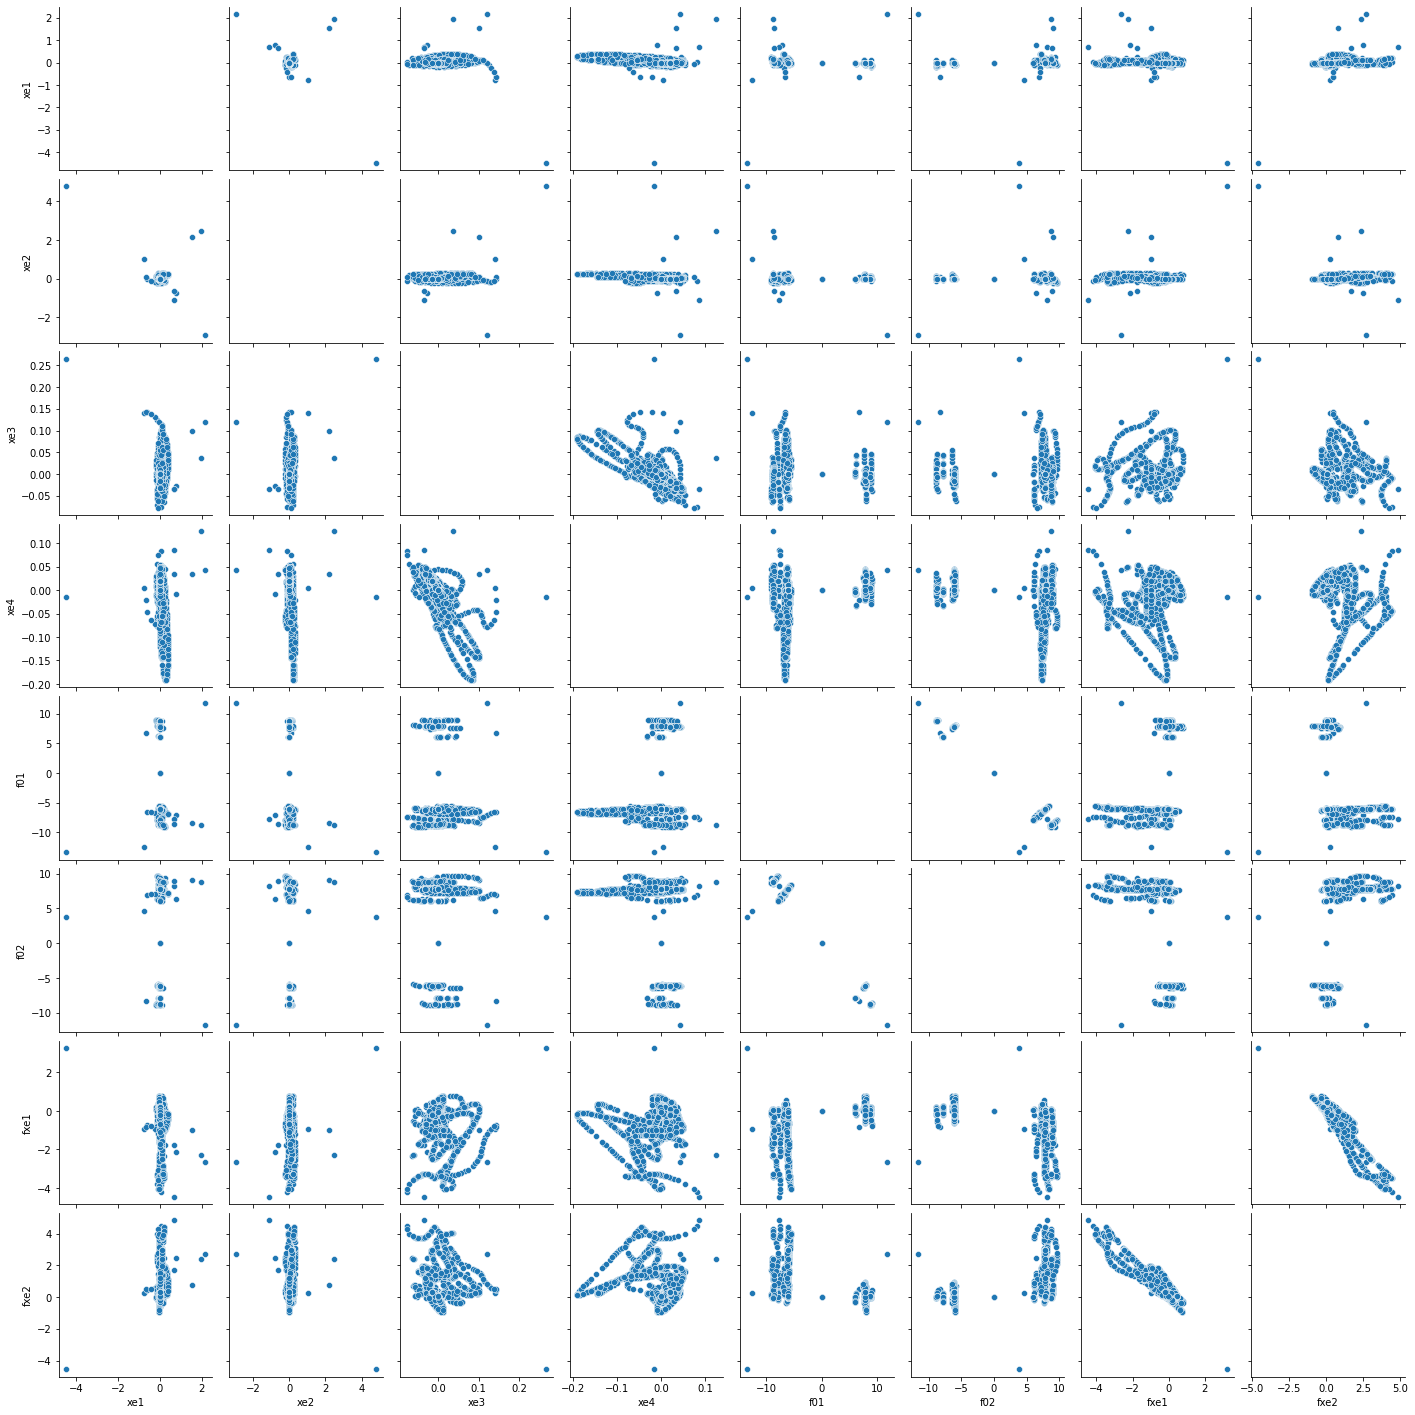

In [11]:
sns.pairplot(train_dataset[['xe1','xe2','xe3','xe4','f01','f02','fxe1','fxe2']], diag_kind='xde')

**Estatísticas dos dados de treino**

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("f01")
train_stats.pop("f02")
train_stats.pop("fxe1")
train_stats.pop("fxe2")
#f01','f02','fxe1','fxe1'

train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
xe1,3199.0,0.016261,0.123284,-4.476779,-0.009520,-0.000032,0.006632,2.167643
xe2,3199.0,0.016972,0.133981,-2.933595,-0.005777,0.000023,0.007395,4.778686
xe3,3199.0,-0.000763,0.023047,-0.077627,-0.012859,-0.000385,0.002965,0.265535
xe4,3199.0,-0.002565,0.033588,-0.191660,-0.003751,0.000062,0.015311,0.126046


**Separação entre as variáveis Preditoras das Alvos**

In [14]:
train_labels = pd.concat([train_dataset.pop("f01"),train_dataset.pop("f02"), train_dataset.pop("fxe1"),train_dataset.pop("fxe2")], axis=1)

test_labels = pd.concat([test_dataset.pop("f01"),test_dataset.pop("f02"), test_dataset.pop("fxe1"),test_dataset.pop("fxe2")], axis=1)

**Nomarlização dos Dados**

Função padroniza realiza a normalização dos dados com base em $z_i =\frac{x_i-\bar{x}}{\sigma}, \forall x_i \in X$

É possível obter a média 'mean' e o desvio padrão 'std' a partir das estatíticas geradas anteriormente. Desta forma t

In [54]:
def padroniza(x):
  return (x - train_stats['mean']) / train_stats['std']

In [55]:
normed_train_data = padroniza(train_dataset)
normed_test_data = padroniza(test_dataset)

In [59]:
normed_test_data

,xe1,xe2,xe3,xe4
0,-0.131897,-0.126675,0.033110,0.076373
3,-0.134095,-0.128697,0.032252,0.075784
7,-0.135507,-0.129996,0.029428,0.073846
21,-0.132245,-0.126913,0.023151,0.069480
24,-0.131524,-0.126191,0.023325,0.069542
...,...,...,...,...
3964,-0.131909,-0.126684,0.033111,0.076384
3968,-0.131909,-0.126684,0.033111,0.076383
3969,-0.131909,-0.126684,0.033111,0.076383
3972,-0.131909,-0.126684,0.033111,0.076383


In [60]:
normed_train_data

,xe1,xe2,xe3,xe4
3190,0.936736,2.058223,0.874170,-2.216033
1473,-0.306257,-0.298146,-0.475784,0.669180
3068,0.046254,0.041646,-0.789338,0.669667
1044,-0.164594,0.026100,-0.088917,0.143028
3794,-0.059806,-0.128973,0.088717,-0.036399
...,...,...,...,...
622,-0.141441,-0.135932,0.165812,-0.020312
3687,-0.132325,-0.126547,0.030604,0.078673
409,0.004857,-0.087765,-1.390791,1.076873
2684,-0.111434,-0.111692,0.013623,0.073898


**Elaboração do Modelo**

Utilizaremos o modelo Sequential, com camadas densamente conectadas, e a camada de saída deve retornar um valor contínuo (não discreto).

Como o modelo é de Regressão, podemos utilizar a MSE - Erro Quadrado Médio (Mean Squared Error)

Como otimizador, será utilizado o SGD - Gradiente Estocástico Descente (Stochastic Gradient Descent)


In [20]:
def constroi_modelo():

  # modelo sequencial, com camadas densamente conectadas
  # Função de ativação ReLU (boa para evitar o decaimento excessivo dos pesos e do gradiente)
  # output de um valor numérico, na última camada
  model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(200, activation='relu'),
    layers.Dense(4)
  ])

  # escolha do otimizador - SGD
  optimizer = 'adam'

  # Função de custo Erro Quadrado Médio (Mean Squared Error)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'acc'])
  return model

In [22]:
model = constroi_modelo()
model

Resumo do modelo criado

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 21,504
Trainable params: 21,504
Non-trainable params: 0
_________________________________________________________________


**Testando o Modelo**

Selecionou-se um conjunto de 10 exemplos

In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.14614008,  0.0521346 ,  0.42261666,  0.21381281],
       [-0.04311915,  0.06728847,  0.07769105,  0.11008936],
       [-0.01131652,  0.05728084,  0.10900871,  0.13834143],
       [-0.01361737,  0.01306564,  0.00778871,  0.02962807],
       [-0.01801039,  0.02602045, -0.00615183,  0.02347059],
       [-0.02496417,  0.03033638, -0.00162961,  0.03305157],
       [-0.05606073,  0.09401481,  0.1805189 ,  0.26105312],
       [-0.10743813,  0.02720859,  0.00701748,  0.06814848],
       [-0.02746898,  0.03125789,  0.00753447,  0.03549505],
       [-0.01030166,  0.07024255,  0.1315527 ,  0.10390503]],
      dtype=float32)

**Treinamento do Modelo**

Definir a quantidade de EPOCHs e armazenar a acurácia e a validação em um histórico de treinamento

In [25]:
## Esta classe auxilia a visualização do progresso
class MostraProgresso(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
      print('')
    print('-', end='')

In [61]:
EPOCHS = 1000

Apesar da definição do número de EPOCHs de treinamento, definiu-se a técnica de *early stop* cessando o treinamendo quando o score de validação não aumentar mais. Essa ténica foi utilizada no tutorial e apresentou grande melhora de performance, reduzindo o tempo de treimento.

In [30]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    x=normed_train_data,
    y = train_labels,
    epochs=EPOCHS,
    validation_split = 0.2,
    verbose=0,
    callbacks=[early_stop,MostraProgresso()]
)


-----------------------

In [31]:
history.__dict__.keys()

dict_keys(['validation_data', 'model', '_chief_worker_only', '_supports_tf_logs', 'history', 'params', 'epoch'])

In [32]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'acc', 'val_loss', 'val_mae', 'val_mse', 'val_acc'])

In [33]:
historico = pd.DataFrame(history.history)
historico['epoch'] = history.epoch
historico.tail()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
18,1.305793,0.314140,1.305793,0.985932,15.808992,0.534411,15.808992,0.975000,18
19,1.456688,0.337807,1.456688,0.984369,16.443272,0.507121,16.443272,0.978125,19
20,1.315494,0.317140,1.315494,0.984760,16.900410,0.516247,16.900410,0.981250,20
21,1.165514,0.302223,1.165514,0.987495,15.287005,0.462571,15.287005,0.979688,21
22,1.158601,0.298795,1.158601,0.985541,14.164528,0.467867,14.164528,0.979688,22


In [34]:
historico.describe()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000
mean,1.302395,0.322032,1.302395,0.985558,13.929270,0.507400,13.929270,0.980503,11.00000
std,0.106242,0.018972,0.106242,0.001282,1.966402,0.025975,1.966402,0.001992,6.78233
min,1.157889,0.293317,1.157889,0.982415,9.378399,0.462571,9.378399,0.975000,0.00000
25%,1.223468,0.306038,1.223468,0.984564,12.603949,0.495859,12.603949,0.979688,5.50000
50%,1.305793,0.320457,1.305793,0.985541,14.164528,0.509140,14.164528,0.979688,11.00000
75%,1.374188,0.337919,1.374188,0.986323,15.446739,0.518397,15.446739,0.981250,16.50000
max,1.534063,0.348305,1.534063,0.987886,16.900410,0.573300,16.900410,0.984375,22.00000


Apresentação dos dados de treinamento em formato gráfico.

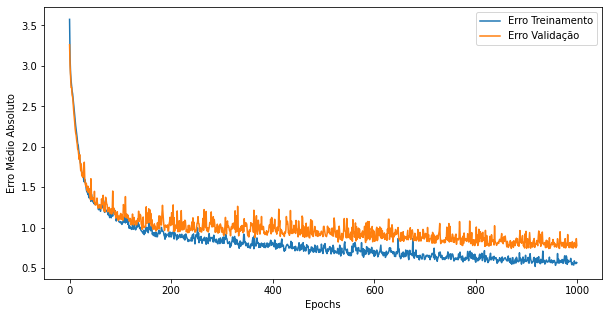

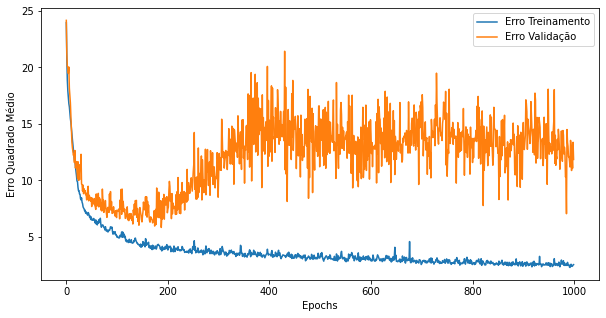

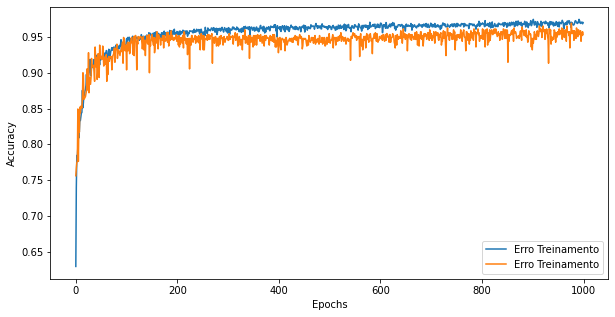

In [99]:
def plota_historico (history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(10,5))
  plt.xlabel('Epochs')
  plt.ylabel('Erro Médio Absoluto')
  plt.plot(hist['epoch'], hist['mae'], label='Erro Treinamento')
  plt.legend(loc='best')

  plt.plot(hist['epoch'], hist['val_mae'], label='Erro Validação')
  plt.legend(loc='best')

  plt.figure(figsize=(10,5))
  plt.xlabel('Epochs')
  plt.ylabel('Erro Quadrado Médio')
  plt.plot(hist['epoch'], hist['mse'], label='Erro Treinamento')
  plt.legend(loc='best')

  plt.plot(hist['epoch'], hist['val_mse'], label='Erro Validação')
  plt.legend(loc='best')

  plt.figure(figsize=(10,5))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'], label='Erro Treinamento')
  plt.legend(loc='best')

  plt.plot(hist['epoch'], hist['val_acc'], label='Erro Treinamento')
  plt.legend(loc='best')
  plt.show()

plota_historico(history)

In [37]:
loss, mae, mse, acc = model.evaluate(normed_test_data, test_labels, verbose=2)

print(" \n Erro Absoluto Médio de Teste: {:5.2f} \n ".format(mae))


25/25 - 0s - loss: 2.4673 - mae: 0.4181 - mse: 2.4673 - acc: 0.9737 - 43ms/epoch - 2ms/step
 
 Erro Absoluto Médio de Teste:  0.42 
 


**Previsões**

Com base no conjunto de testes separados anteriormente, serão realizadas as previsões de F0 e Fxe.

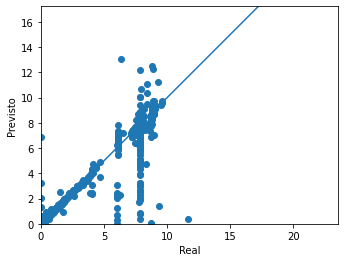

In [46]:
previsoes_teste = model.predict(normed_test_data)

plt.scatter(test_labels, previsoes_teste)
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100,100], [-100,100])

In [47]:
previsoes_teste

array([[ 6.8588972e+00, -5.9824638e+00,  1.1036068e-02,  6.4428478e-02],
       [ 6.0952110e+00, -5.6501455e+00,  2.2143126e-04,  6.8591565e-02],
       [ 2.9638608e+00, -2.8241451e+00, -2.7281046e-03,  4.5347065e-02],
       ...,
       [ 6.8916559e+00, -6.0106888e+00,  1.1108667e-02,  6.4413458e-02],
       [ 6.8913012e+00, -6.0104637e+00,  1.1105299e-02,  6.4414948e-02],
       [ 6.8896465e+00, -6.0095358e+00,  1.1086643e-02,  6.4421147e-02]],
      dtype=float32)

In [48]:
test_labels

,f01,f02,fxe1,fxe2
0,0.000000,0.000000,0.000000,0.000000
3,7.878922,-6.064276,0.000032,0.000032
7,7.879545,-6.063652,0.000335,0.000335
21,-6.064004,7.879188,0.003061,0.003063
24,-6.063980,7.879208,0.003725,0.003730
...,...,...,...,...
3964,7.844266,-6.100726,0.034277,0.036054
3968,7.844266,-6.100726,0.034277,0.036054
3969,7.844266,-6.100726,0.034277,0.036054
3972,7.844266,-6.100726,0.034277,0.036053


**Distribuição dos Erros**

Verificar se os erros são aproximadamente Gaussianos.

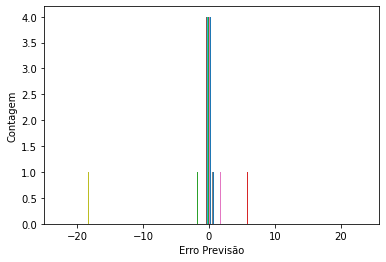

In [65]:
erro = previsoes_teste - test_labels

plt.hist(erro, bins=50)
plt.xlabel("Erro Previsão")
_ = plt.ylabel("Contagem")
plt.show()

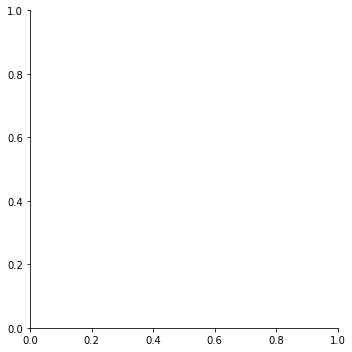

In [64]:
sns.displot(a=erro, bins = 50)
plt.show()